# Scanning Session Ingestion

## Setup

### Connect to the database

If you are don't have your login information, contact the administrator.

Using local config file (see [01_pipeline](./01_pipeline.ipynb)):

Check out the respective elements video: https://www.youtube.com/watch?v=DLYqnj40eAM

Use this as info NB https://github.com/SFB1089/workflow-calcium-imaging/blob/main/notebooks/07-downstream-analysis-optional.ipynb


In [1]:
import os
# change to the upper level folder to detect dj_local_conf.json
if os.path.basename(os.getcwd())=='notebooks': os.chdir('..')
assert os.path.basename(os.getcwd())=='adamacs', ("Please move to the main directory")
import datajoint as dj; dj.conn()


[2023-05-09 09:35:56,999][INFO]: Connecting tobiasr@172.26.128.53:3306
[2023-05-09 09:35:57,045][INFO]: Connected tobiasr@172.26.128.53:3306


DataJoint connection (connected) tobiasr@172.26.128.53:3306

Manual entry:

### Imports and activation

Importing schema from `adamacs.pipeline` automatically activates relevant schema.

In [23]:
import datajoint as dj
from adamacs.pipeline import subject, session, surgery, scan, event, trial, imaging
from adamacs import utility
from adamacs.ingest import behavior as ibe
from pywavesurfer import ws
import matplotlib.pyplot as plt
# check https://elements.datajoint.org/description/event/ for doc

Assign easy names for relevant tables

In [3]:
sub, lab, protocol, line, mutation, user, project, subject_genotype, subject_death = (
    subject.Subject(), subject.Lab(), subject.Protocol(), subject.Line(), 
    subject.Mutation(), subject.User(), subject.Project(), subject.SubjectGenotype(), 
    subject.SubjectDeath())

## Ingesting behavior

In [ ]:
ibe.ingest_aux("sess9FHELAYA","scan9FHELX2S", verbose=True)

In [18]:
scansi = "scan9FHELX2S"
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0]

In [9]:
event.Event()  &  "event_type='HARP_gate'"


session_id,scan_id,event_type,event_start_time (second) relative to recording start,event_end_time (second) relative to recording start
sess9FHELAYA,scan9FHELAYA,HARP_gate,2.31135,602.724
sess9FHS7Y22,scan9FHS7Y22,HARP_gate,2.235,602.641
sess9FHS7Y22,scan9FHS845A,HARP_gate,1.9852,602.413


In [10]:
event.Event()  &  "event_type='shutter'" 


session_id,scan_id,event_type,event_start_time (second) relative to recording start,event_end_time (second) relative to recording start
sess9FHELAYA,scan9FHELAYA,shutter,2.0942,2.81215
sess9FHELAYA,scan9FHELAYA,shutter,4.6361,602.708
sess9FHS7Y22,scan9FHS7Y22,shutter,2.0279,2.67805
sess9FHS7Y22,scan9FHS7Y22,shutter,4.57,602.623
sess9FHS7Y22,scan9FHS845A,shutter,1.7695,2.46435
sess9FHS7Y22,scan9FHS845A,shutter,4.3157,602.398


In [13]:
event.Event()  &  "event_type='arena_LED'" &  "scan_id='scan9FHS7Y22'"


session_id,scan_id,event_type,event_start_time (second) relative to recording start,event_end_time (second) relative to recording start
sess9FHS7Y22,scan9FHS7Y22,arena_LED,3.8,4.29995
sess9FHS7Y22,scan9FHS7Y22,arena_LED,7.9,8.39995
sess9FHS7Y22,scan9FHS7Y22,arena_LED,11.0,11.5
sess9FHS7Y22,scan9FHS7Y22,arena_LED,12.7,13.2
sess9FHS7Y22,scan9FHS7Y22,arena_LED,16.2,16.6999
sess9FHS7Y22,scan9FHS7Y22,arena_LED,18.9,19.4
sess9FHS7Y22,scan9FHS7Y22,arena_LED,22.5,23.0
sess9FHS7Y22,scan9FHS7Y22,arena_LED,26.8,27.2999
sess9FHS7Y22,scan9FHS7Y22,arena_LED,30.6,31.1
sess9FHS7Y22,scan9FHS7Y22,arena_LED,32.9,33.3999


In [11]:
event.EventType()

event_type,event_type_description
arena_LED,
aux_bpod_cam,
aux_bpod_reward,
aux_bpod_tone,
aux_bpod_visual,
aux_cam,
HARP_gate,
main_track_gate,
mini2p_frames,
mini2p_lines,


In [8]:
event.Event()

session_id,scan_id,event_type,event_start_time (second) relative to recording start,event_end_time (second) relative to recording start
sess9FHS7Y22,scan9FHS7Y22,arena_LED,3.8,4.29995
sess9FHS7Y22,scan9FHS7Y22,arena_LED,7.9,8.39995
sess9FHS7Y22,scan9FHS7Y22,arena_LED,11.0,11.5
sess9FHS7Y22,scan9FHS7Y22,arena_LED,12.7,13.2
sess9FHS7Y22,scan9FHS7Y22,arena_LED,16.2,16.6999
sess9FHS7Y22,scan9FHS7Y22,arena_LED,18.9,19.4
sess9FHS7Y22,scan9FHS7Y22,arena_LED,22.5,23.0
sess9FHS7Y22,scan9FHS7Y22,arena_LED,26.8,27.2999
sess9FHS7Y22,scan9FHS7Y22,arena_LED,30.6,31.1
sess9FHS7Y22,scan9FHS7Y22,arena_LED,32.9,33.3999


In [20]:
auxpath = (event.BehaviorRecording.File() & scan_key).fetch('filepath')
print(auxpath)

['/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELX2S_sess9FHELAYA/scan9FHELX2S_RN_OPI-1681_0008.h5']


In [21]:
curr_file = ws.loadDataFile(filename=auxpath[0], format_string='double' )
sweep = "sweep_0008"

/home/tobiasr/miniconda3/envs/dj/lib/python3.8/site-packages/pywavesurfer/ws.py:46: RuntimeWarning: You are reading a WaveSurfer file version this module was not tested with: file version 1.0.6, latest version tested: 0.982
  warnings.warn('You are reading a WaveSurfer file version this module was not tested with: '


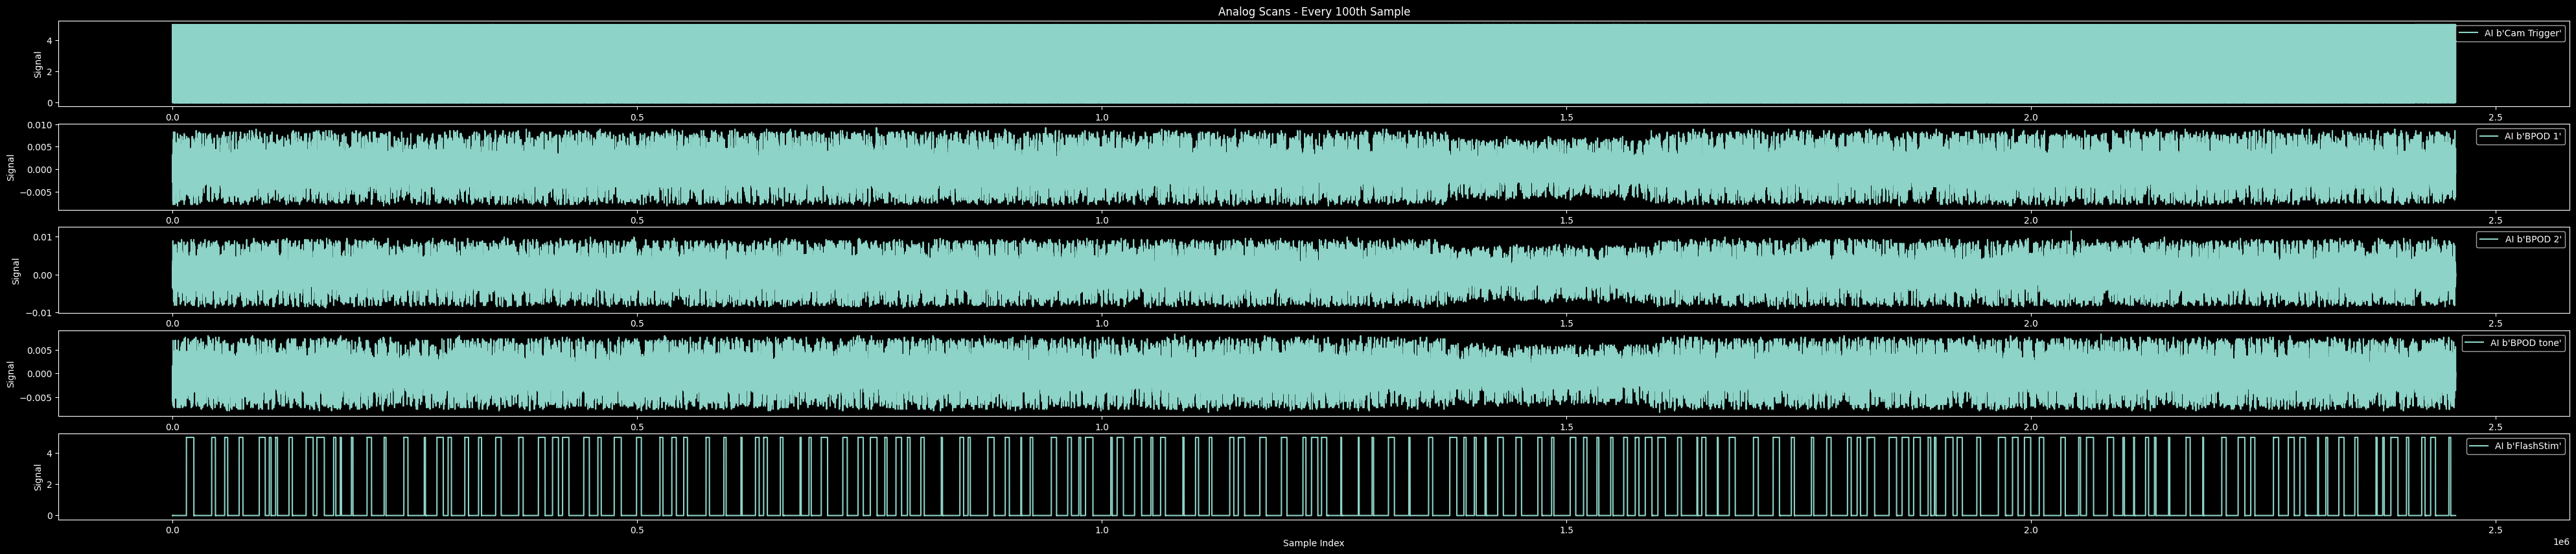

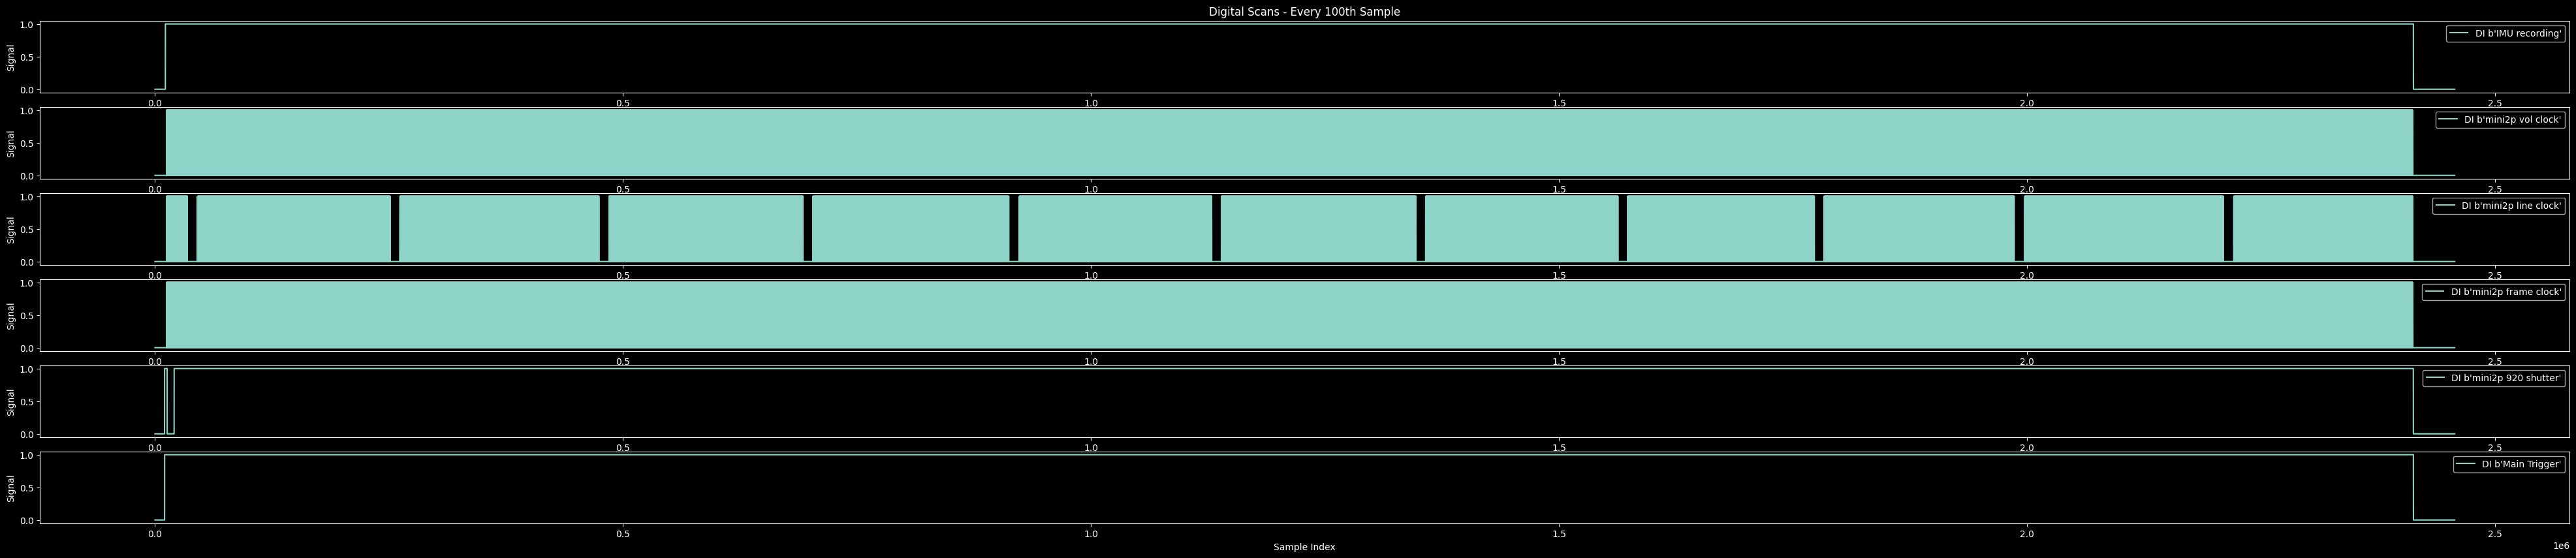

In [32]:
analog_scans = curr_file[sweep]['analogScans']
analog_labels = curr_file['header']['AIChannelNames']
digital_scans = ibe.demultiplex(curr_file[sweep]['digitalScans'][0], 6)
digital_labels = curr_file['header']['DIChannelNames']
step = 5

# Plotting analogScans
# plt.figure(figsize=(12, 6))
# plt.title("Analog Scans")

# Creating subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(50, 10))

# Plotting analogScans
axes[0].set_title("Analog Scans - Every 100th Sample")
for i in range(analog_scans.shape[0]):
     axes[i].plot(analog_scans[i][::step], label=f"AI {analog_labels[i]}")
     axes[i].legend()
     axes[i].set_xlabel("Sample Index")
     axes[i].set_ylabel("Signal")

plt.show()


# Creating subplots
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(50, 10))

# Plotting analogScans
axes[0].set_title("Digital Scans - Every 100th Sample")
for i in range(digital_scans.shape[0]):
     axes[i].plot(digital_scans[i][::step], label=f"DI {digital_labels[::-1][i]}")
     axes[i].set_xlabel("Sample Index")
     axes[i].set_ylabel("Signal")
     axes[i].legend()
plt.show()


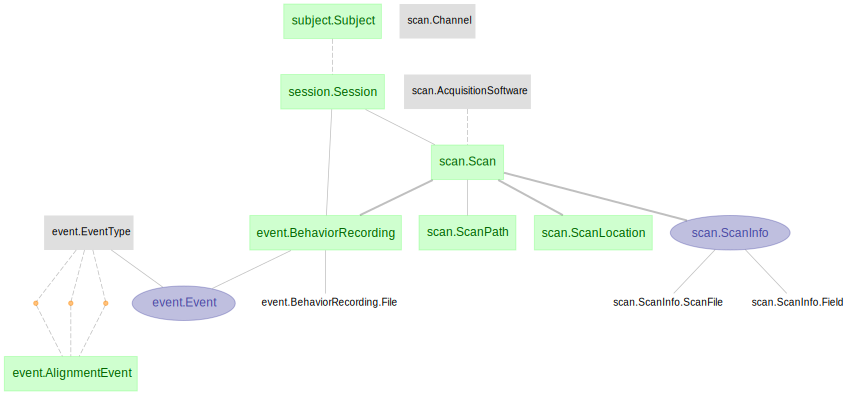

In [33]:
dj.Diagram(subject.Subject) + dj.Diagram(event) + dj.Diagram(scan)

In [36]:
fp = event.BehaviorRecording.File().fetch('filepath')
print(fp)


['/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELAYA_sess9FHELAYA/scan9FHELAYA_RN_OPI-1681_0006.h5'
 '/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELMRY_sess9FHELAYA/scan9FHELMRY_RN_OPI-1681_0007.h5'
 '/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELX2S_sess9FHELAYA/scan9FHELX2S_RN_OPI-1681_0008.h5'
 '/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHEMBE2_sess9FHELAYA/scan9FHEMBE2_RN_OPI-1681_0011.h5'
 '/datajoint-data/data/tobiasr/NK_ROS-1485_2023-04-28_scan9FHS7Y22_sess9FHS7Y22/scan9FHS7Y22_NK_ROS-1485_2024.h5'
 '/datajoint-data/data/tobiasr/NK_ROS-1485_2023-04-28_scan9FHS845A_sess9FHS7Y22/scan9FHS845A_NK_ROS-1485_2025.h5']


In [37]:
scan.Scan()

session_id,scan_id,scanner,acq_software,scan_notes free-notes
sess9FHELAYA,scan9FHELAYA,bench2p,ScanImage,none
sess9FHELAYA,scan9FHELMRY,bench2p,ScanImage,none
sess9FHELAYA,scan9FHELX2S,bench2p,ScanImage,none
sess9FHELAYA,scan9FHEMBE2,bench2p,ScanImage,none
sess9FHS7Y22,scan9FHS7Y22,mini2p_05,ScanImage,none
sess9FHS7Y22,scan9FHS845A,mini2p_05,ScanImage,none


In [39]:
event.AlignmentEvent()

alignment_name,alignment_description,alignment_event_type,alignment_time_shift (s) WRT alignment_event_type,start_event_type,start_time_shift (s) WRT start_event_type,end_event_type,end_time_shift (s) WRT end_event_type


In [40]:
trial.Trial()

session_id,scan_id,trial_id trial number (1-based indexing),trial_type,trial_start_time (second) relative to recording start,trial_stop_time (second) relative to recording start


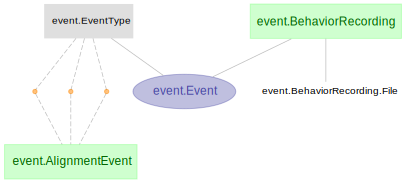

In [41]:
dj.Diagram(event)

In [42]:
session.Session * session.SessionDirectory

session_id,subject PyRat import uses this for earmark value,session_datetime,session_dir Path to the data directory for a session,user_id
sess9FHELAYA,OPI-1681,2023-04-05 00:00:00,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELX2S_sess9FHELAYA,7
sess9FHS7Y22,ROS-1485,2023-04-28 00:00:00,/datajoint-data/data/tobiasr/NK_ROS-1485_2023-04-28_scan9FHS7Y22_sess9FHS7Y22,3


In [43]:
key='scan9FF6U114'
(scan.Scan & f'scan_id=\"{key}\"')

session_id,scan_id,scanner,acq_software,scan_notes free-notes


In [44]:
scan.Scan()

session_id,scan_id,scanner,acq_software,scan_notes free-notes
sess9FHELAYA,scan9FHELAYA,bench2p,ScanImage,none
sess9FHELAYA,scan9FHELMRY,bench2p,ScanImage,none
sess9FHELAYA,scan9FHELX2S,bench2p,ScanImage,none
sess9FHELAYA,scan9FHEMBE2,bench2p,ScanImage,none
sess9FHS7Y22,scan9FHS7Y22,mini2p_05,ScanImage,none
sess9FHS7Y22,scan9FHS845A,mini2p_05,ScanImage,none


`CB DEV NOTE:` In demo file, there are no `scan.motor_position_at_zero` values. Set to 0 here to avoid downstream type errors when adding. Future would should set these to null when not present and revise downstream code.

In [45]:
scan.ScanInfo()

session_id,scan_id,nfields number of fields,nchannels number of channels,ndepths Number of scanning depths (planes),nframes number of recorded frames,nrois number of ROIs (see scanimage's multi ROI imaging),x (um) ScanImage's 0 point in the motor coordinate system,y (um) ScanImage's 0 point in the motor coordinate system,z (um) ScanImage's 0 point in the motor coordinate system,fps (Hz) frames per second - Volumetric Scan Rate,bidirectional true = bidirectional scanning,usecs_per_line microseconds per scan line,fill_fraction raster scan temporal fill fraction (see scanimage),scan_datetime datetime of the scan,scan_duration (seconds) duration of the scan,userfunction_info string argument of file consolidation userfunction 1
sess9FHELAYA,scan9FHELAYA,1,1,1,9230,0,-2687.11,-30474300.0,-123831000.0,15.3845,1,250.001,0.95,None,599.955,openfield
sess9FHELAYA,scan9FHELMRY,1,1,1,9230,0,-2687.11,-30474300.0,-123831000.0,15.3845,1,250.001,0.95,None,599.955,openfield
sess9FHELAYA,scan9FHELX2S,1,1,1,9230,0,-2687.11,-30474300.0,-123831000.0,15.3845,1,250.001,0.95,None,599.955,openfield
sess9FHELAYA,scan9FHEMBE2,1,1,1,9230,0,-2687.11,-30474300.0,-123831000.0,15.3845,1,250.001,0.95,None,599.955,openfield
sess9FHS7Y22,scan9FHS7Y22,1,1,1,9230,0,0.0,0.0,0.0,15.3845,1,250.003,0.9,None,599.955,openfield
sess9FHS7Y22,scan9FHS845A,1,1,1,9230,0,0.0,0.0,0.0,15.3845,1,250.003,0.9,None,599.955,openfield


In [46]:
scan.ScanInfo.Field()

session_id,scan_id,field_idx,px_height height in pixels,px_width width in pixels,um_height height in microns,um_width width in microns,zoom scan zoom factor,field_x (um) center of field in the motor coordinate system,field_y (um) center of field in the motor coordinate system,field_z (um) relative depth of field,delay_image (ms) delay between the start of the scan and pixels in this field,roi the scanning roi (as recorded in the acquisition software) containing this field - only relevant to mesoscale scans
sess9FHELAYA,scan9FHELAYA,0,256,256,164.491,164.491,1.0,-2687.11,-30474300.0,-123831000.0,=BLOB=,None
sess9FHELAYA,scan9FHELMRY,0,256,256,164.491,164.491,1.0,-2687.11,-30474300.0,-123831000.0,=BLOB=,None
sess9FHELAYA,scan9FHELX2S,0,256,256,164.491,164.491,1.0,-2687.11,-30474300.0,-123831000.0,=BLOB=,None
sess9FHELAYA,scan9FHEMBE2,0,256,256,164.491,164.491,1.0,-2687.11,-30474300.0,-123831000.0,=BLOB=,None
sess9FHS7Y22,scan9FHS7Y22,0,256,256,162.969,162.969,1.0,nan,nan,nan,=BLOB=,None
sess9FHS7Y22,scan9FHS845A,0,256,256,162.969,162.969,1.0,nan,nan,nan,=BLOB=,None


Note the relative path below:

In [47]:
scan.ScanInfo.ScanFile()

session_id,scan_id,file_path filepath relative to root data directory
sess9FHELAYA,scan9FHELAYA,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELAYA_sess9FHELAYA/scan9FHELAYA_RN_OPI-1681_00006_00001.tif
sess9FHELAYA,scan9FHELMRY,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELMRY_sess9FHELAYA/scan9FHELMRY_RN_OPI-1681_00007_00001.tif
sess9FHELAYA,scan9FHELX2S,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELX2S_sess9FHELAYA/scan9FHELX2S_RN_OPI-1681_00008_00001.tif
sess9FHELAYA,scan9FHEMBE2,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHEMBE2_sess9FHELAYA/scan9FHEMBE2_RN_OPI-1681_00011_00001.tif
sess9FHS7Y22,scan9FHS7Y22,/datajoint-data/data/tobiasr/NK_ROS-1485_2023-04-28_scan9FHS7Y22_sess9FHS7Y22/scan9FHS7Y22_NK_ROS-1485_02024.tif
sess9FHS7Y22,scan9FHS845A,/datajoint-data/data/tobiasr/NK_ROS-1485_2023-04-28_scan9FHS845A_sess9FHS7Y22/scan9FHS845A_NK_ROS-1485_02025.tif
